# Read in the data

**SAT scores by school**: SAT scores for each high school in New York City

**School Attendance**: Attendance info for each school in NYC

**Class Size**: Information on class size for each school

**AP test results**: AP exam text results for high school students

**Graduation Outcomes**: The % of students who graduated, and other outcome info


**Demographics**: Demographic info for each school
School Survey: Survey of parents, teachers, and students for each school

In [59]:
import pandas
import numpy
import re

data_files = [    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"    
]

data = {}

for f in data_files:
    dataframe = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv","")] =  dataframe

# Read in the surveys

In [60]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [61]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [62]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [63]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [64]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [65]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [66]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [67]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

### Correlation of Survey Fields and SAT Score

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

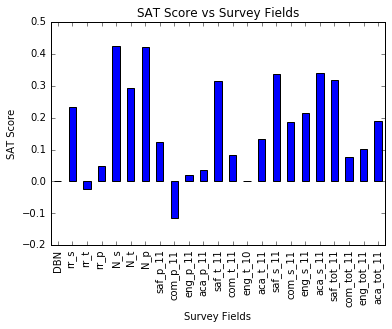

In [69]:
figure = plt.figure()
plt.title("SAT Score vs Survey Fields")
plt.xlabel("Survey Fields")
plt.ylabel("SAT Score")
combined.corr()["sat_score"][survey_fields].plot.bar()

There are high correlations between N_s, N_t, N_p and sat_score. 

### Explore Safety and SAT Scores

saf_t_11 and saf_s_11 measure how teachers and students perceive safety at school. We see these two features being correlated with sat_score.

We are interested in observing which schools have low safety scores, given that the two features are correlated with sat_score.

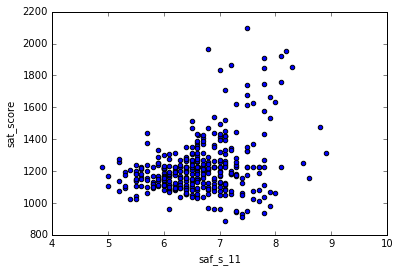

In [70]:
plt.scatter(x = combined["saf_s_11"], y = combined["sat_score"])
plt.xlabel("saf_s_11")
plt.ylabel("sat_score")
plt.show()

We observe  a weak positive correlation with student safety and SAT score.

We also observe that for some low level safety concern from students, the likelihood of their SAT scores are low. However, this does not imply the case, but does raise some concern.

In [71]:
district = combined.groupby("school_dist").agg(numpy.mean)
district.reset_index(inplace = True)


In [72]:
print(district.head())

  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   
1          02                       426.619092           444.186256   
2          03                       428.529851           437.997512   
3          04                       402.142857           416.285714   
4          05                       427.159915           438.236674   

   SAT Writing Avg. Score    sat_score  AP Test Takers   Total Exams Taken  \
0              439.333333  1354.500000       116.681090         173.019231   
1              424.832836  1295.638184       128.908454         201.516827   
2              426.915672  1293.443035       156.183494         244.522436   
3              405.714286  1224.142857       129.016484         183.879121   
4              419.666098  1285.062687        85.722527         115.725275   

   Number of Exams with scores 3 4 or 5  Total Cohort  CSD    ...      \
0                            13

In [73]:
from mpl_toolkits.basemap import Basemap

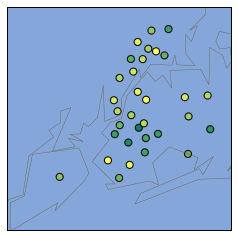

In [74]:
m = Basemap(    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i')
# draw coastlines, country boundaries, fill continents.

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = district["lon"].tolist()
latitudes = district["lat"].tolist()
m.scatter(x = longitudes, y = latitudes, zorder = True, s = 50, latlon = "True",c=district["saf_s_11"], cmap="summer")

plt.show()

The yellow dotted points in the New York region above display the locations with higher scores. The green dotted points display lowere ssafety scores. 

We observe that locations mid south of New York have lower average safety scores.

### Exploring Race and SAT Scores

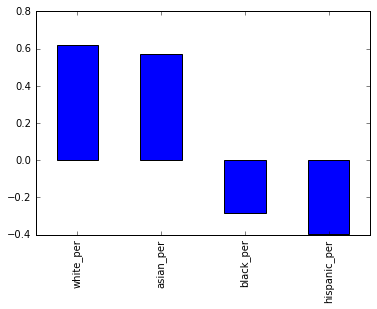

In [75]:
race_per = ["white_per","asian_per","black_per","hispanic_per"]
combined.corr()["sat_score"][race_per].plot.bar()

We see a significant difference between white_per and asian_per compared to the latter two racial groups. There is an unexpected correlation between the previously first mentioned groups. However, we can justify this observation by the social nature and progression of the white and asian groups as opposed to the others.

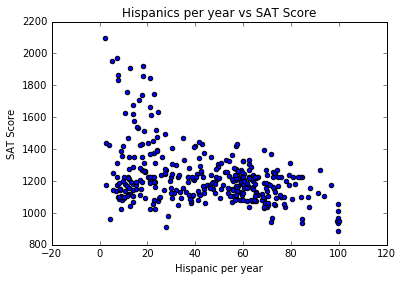

In [76]:
plt.scatter( x = combined["hispanic_per"], y = combined["sat_score"])
plt.xlabel("Hispanic per year")
plt.ylabel("SAT Score")
plt.title("Hispanics per year vs SAT Score")
plt.show()

There appears to be a negative andd quadratic association for Hispanics per year with SAT Scores

In [77]:
district_hispanic_per95 = combined[combined["hispanic_per"] >95]

Schoool's with hispanic_per greater than 95% are listed below:

'MANHATTAN BRIDGES HIGH SCHOOL', 

'WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL', \

'GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS', 

'ACADEMY FOR LANGUAGE AND TECHNOLOGY', 

'INTERNATIONAL SCHOOL FOR LIBERAL ARTS', 

'PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE', 
'MULTICULTURAL HIGH SCHOOL', 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL']

All of these NY related schools gear towards admitting minorities with lack of english proficiency compared to native english speakers

In [78]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])


37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Exploring Gender and SAT Scores

In [93]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

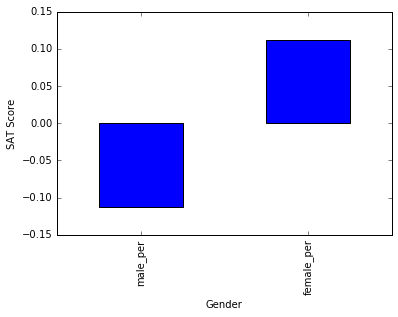

In [80]:
gender_fields = ["male_per", "female_per"]
plt.xlabel("Gender")
plt.ylabel("SAT Score")
combined.corr()["sat_score"][gender_fields].plot.bar()
plt.show()

We observe that females tend to score higher than male counter parts in the SAT examination

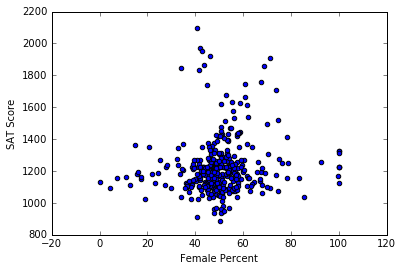

In [81]:
plt.xlabel("Female Percent")
plt.ylabel("SAT Score")
plt.scatter(x=combined["female_per"],y=combined["sat_score"])
plt.show()

In [82]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])


5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The above schools are liberal art schools

### Exploring AP Score Vs SAT Scores

In [83]:
ap_per = combined["AP Test Takers "]/ combined["total_enrollment"]

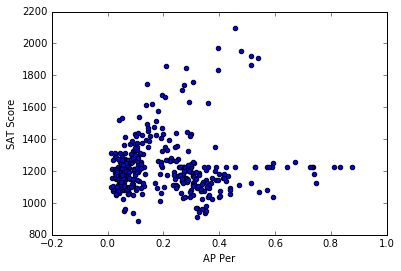

In [84]:
plt.scatter(x= ap_per, y = combined["sat_score"])
plt.ylabel("SAT Score")
plt.xlabel("AP Per")
plt.show()

### Determining if there is a correlation between class size and SAT Scores

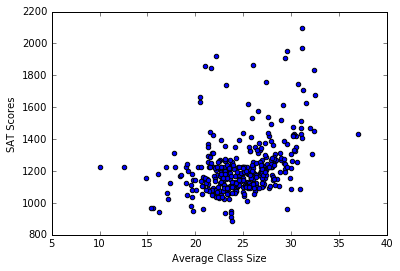

In [95]:
plt.scatter(x = combined["AVERAGE CLASS SIZE"], y = combined["sat_score"])
plt.xlabel("Average Class Size")
plt.ylabel("SAT Scores")
plt.show()


We o

### Ending Notes

Things to do:


Determing wheter there's a correlation between class size and SAT scores


Figuring out which neighborhoods have the best schools
            If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.

Investigating the differences between parent, teacher, and student responses to surveys.

Assigning scores to schools based on sat_score and other attributes.